In [29]:
# Imports
import torch
import torch.nn as nn
torch.cuda.empty_cache()

from utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = get_input_transform(520, IMG_SIZE)

ModuleNotFoundError: No module named 'skimage'

In [2]:
from high_res import HighResDV2

shifts = [1, 2, 3, 4, 5, 6, 7]
net = HighResDV2("dinov2_vits14", shifts, pattern="Moore", dtype=torch.float32, pca_each=False)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Let's look at the test image: some basic shapes with some patterning. Notably some of the features are smaller than the 14x14 patch size. Let's also visualise the shifting data prep the network does, by shifting by a large amount (70px) and plotting. We'll also save it to use in a diagram later.

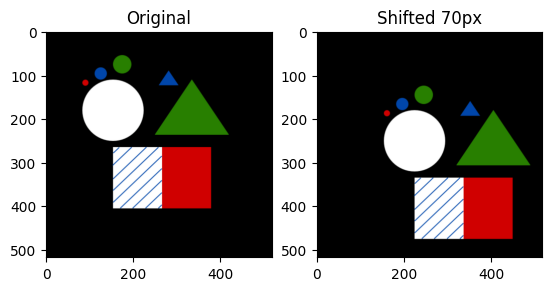

In [3]:
test_tensor, test_img = load_image("data/test_image.png", transform)
test_tensor = test_tensor.to('cuda')

SHIFT = 70
net.shift_distances= [SHIFT]
shifted_img_tensors = net.get_shifted_img_batch(test_tensor).detach().cpu()
shifted_img: Image.Image = to_img(unnormalize(shifted_img_tensors[-1, :, :, :]))


fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].imshow(test_img)
axs[0].set_title("Original")

axs[1].imshow(shifted_img)
axs[1].set_title(f"Shifted {SHIFT}px")

shifted_img.save("out/shifted_input.png")

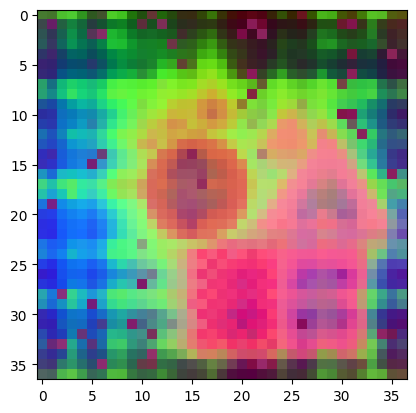

In [4]:
# Get low res features of the shifted image (this is just a call to vanilla DINOv2, so we need to batch)
shift_img_tensor = shifted_img_tensors[-1].unsqueeze(0).cuda()
low_res_feature_batch = net.low_res_features(shift_img_tensor)
low_res_feature_arr = to_numpy(low_res_feature_batch)

shifted_features = do_single_pca(low_res_feature_arr)
# rescale between 0 and 1 for plotting
rescaled_shifted_features = rescale_pca(shifted_features)
rescaled_shifted_feat_img = rescaled_shifted_features.reshape(PATCH_H, PATCH_W, 3)
plt.imshow(rescaled_shifted_feat_img)
plt.imsave("out/shifted_features_lr.png" ,rescaled_shifted_feat_img)


In [5]:
net.shift_distances = shifts # reset the shifts
high_res_features, low_res_features = net(test_tensor)

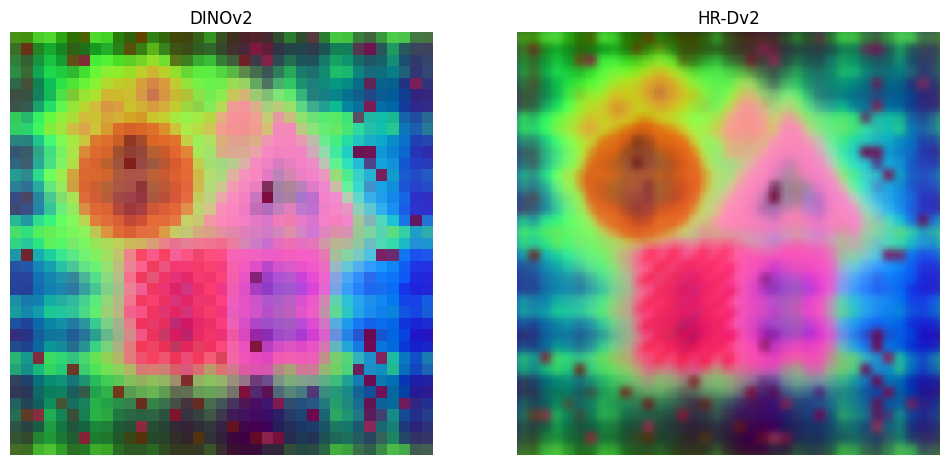

In [46]:
feat_arr_hr, feat_arr_lr = to_numpy(high_res_features), to_numpy(low_res_features)
feat_arr_hr = feat_arr_hr.reshape((net.feat_dim, IMG_SIZE * IMG_SIZE))
feat_arr_hr = feat_arr_hr.T

fig, axs = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(12, 6)
titles = ["DINOv2", "HR-Dv2"]
i = 0
for arr, shapes in zip([feat_arr_lr, feat_arr_hr], [(PATCH_H, PATCH_W, 3), (IMG_SIZE, IMG_SIZE, 3)]):
    feat_pca = do_single_pca(arr)
    rescale_feat_pca = rescale_pca(feat_pca)

    ax = axs[i]
    ax.imshow(rescale_feat_pca.reshape(shapes)[:, :, :])
    ax.set_title(titles[i])
    ax.set_axis_off()
    i += 1 